# 資料讀取與整合
* 數據路徑與對應標籤（正常=0 / 異常=1）

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold 
from settings import *
from torch.utils.tensorboard import SummaryWriter

In [15]:
# 圖片要儲存到哪個資料夾
os.makedirs(RESULT_DIR, exist_ok=True)

all_sequences = []
all_labels = []

def process_file(file_path, label):
    """
    讀取 CSV 檔案並切分為 CHUNK_SIZE 的小段。
    :param file_path: 檔案路徑
    :param label: 該檔案的標籤 (0: 正常, 1: 異常)
    """
    df = pd.read_csv(file_path)
    
    # 假設有 'current', 'voltage', 'power' 3個columns
    current = df['current'].values  # shape: (N,)
    voltage = df['voltage'].values
    power   = df['power'].values
    
    # 組合特徵維度: (N, 3)
    sequence = np.column_stack((current, voltage, power))
    seq_len = sequence.shape[0]
    
    # 將數據切分為 CHUNK_SIZE 的小段
    num_chunks = seq_len // MAX_SEQ_LEN
    for i in range(num_chunks):
        start = i * MAX_SEQ_LEN
        end = start + MAX_SEQ_LEN
        chunk = sequence[start:end]
        all_sequences.append(chunk)
        all_labels.append(label)


# === 讀取 normal 資料夾的 CSV，標籤=0 ===
for filename in os.listdir(NORMAL_DIR):
    if filename.lower().endswith(".csv"):
        file_path = os.path.join(NORMAL_DIR, filename)
        process_file(file_path, label=0)

# === 讀取 abnormal 資料夾的 CSV，標籤=1 ===
for filename in os.listdir(ABNORMAL_DIR):
    if filename.lower().endswith(".csv"):
        file_path = os.path.join(ABNORMAL_DIR, filename)
        process_file(file_path, label=1)
        
# 轉為 numpy array
all_sequences = np.array(all_sequences, dtype=np.float32)  # shape: (num_samples, 30, 3)
all_labels = np.array(all_labels, dtype=np.int64)          # shape: (num_samples,)

print("all_sequences shape:", all_sequences.shape)
print("all_labels shape:", all_labels.shape)
print("Number of normal samples:", np.sum(all_labels == 0))
print("Number of abnormal samples:", np.sum(all_labels == 1))

all_sequences shape: (1228, 10, 3)
all_labels shape: (1228,)
Number of normal samples: 427
Number of abnormal samples: 801


# 自訂 Dataset 與 DataLoader

In [16]:
class ChargingDataset(Dataset):
    def __init__(self, sequences, labels):
        # self.sequences = sequences  # shape: (num_samples, 30, 3)
        # self.labels = labels        # shape: (num_samples,)
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # x = self.sequences[idx]    # (30, 3)
        # y = self.labels[idx]       # 0 or 1
        # x_tensor = torch.tensor(x, dtype=torch.float32)
        # y_tensor = torch.tensor(y, dtype=torch.long)
        # return x_tensor, y_tensor
        return self.sequences[idx], self.labels[idx] 

# LSTM模型
輸入(voltage, current, power) 
輸出(normal / abnormal)

In [17]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes=2, dropout_rate=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        # x: (batch_size, seq_len, input_dim) 可能在 GPU (cuda) 或 CPU
        batch_size = x.size(0)

        # h0: , c0: Initialize cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        # out: (batch_size, seq_len, hidden_dim)
        
        out = out[:, -1, :]  # 取最後時刻的輸出 (batch_size, hidden_dim)
        out = self.dropout(out)
        out = self.fc(out)   # (batch_size, num_classes)
        return out


# K-fold Cross Validation

In [18]:
dataset = ChargingDataset(all_sequences, all_labels)
kfold = StratifiedKFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            running_loss += loss.item() * x_batch.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = running_loss / total
    avg_acc = correct / total if total > 0 else 0
    return avg_loss, avg_acc

# K-fold 訓練


=== Fold 1 / 5 ===
Epoch 1/100 | TrainLoss: 0.6996, TrainAcc: 0.4837 | TestLoss: 0.6264, TestAcc: 0.9919 | Precision: 0.9877, Recall: 1.0000, F1: 0.9938
Epoch 2/100 | TrainLoss: 0.4232, TrainAcc: 0.9338 | TestLoss: 0.2424, TestAcc: 0.9878 | Precision: 0.9876, Recall: 0.9938, F1: 0.9907
Epoch 3/100 | TrainLoss: 0.2344, TrainAcc: 0.9695 | TestLoss: 0.1624, TestAcc: 0.9878 | Precision: 0.9876, Recall: 0.9938, F1: 0.9907
Epoch 4/100 | TrainLoss: 0.1937, TrainAcc: 0.9695 | TestLoss: 0.1237, TestAcc: 0.9878 | Precision: 0.9876, Recall: 0.9938, F1: 0.9907
Epoch 5/100 | TrainLoss: 0.1721, TrainAcc: 0.9695 | TestLoss: 0.1004, TestAcc: 0.9878 | Precision: 0.9876, Recall: 0.9938, F1: 0.9907
Epoch 6/100 | TrainLoss: 0.1599, TrainAcc: 0.9695 | TestLoss: 0.0879, TestAcc: 0.9878 | Precision: 0.9876, Recall: 0.9938, F1: 0.9907
Epoch 7/100 | TrainLoss: 0.1456, TrainAcc: 0.9695 | TestLoss: 0.0800, TestAcc: 0.9878 | Precision: 0.9876, Recall: 0.9938, F1: 0.9907
Epoch 8/100 | TrainLoss: 0.1495, TrainAcc:

<Figure size 400x400 with 0 Axes>

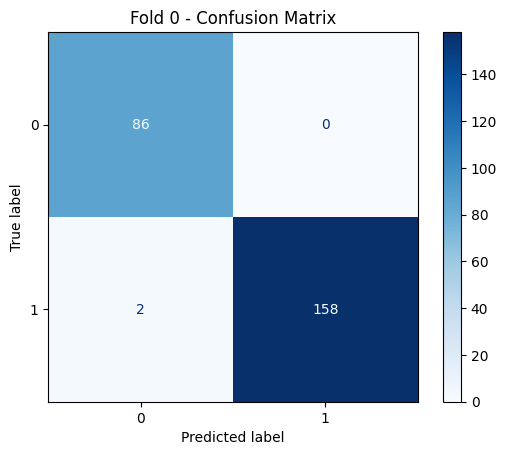

Model for fold 0 saved to result/fold_0_model.pth

=== Fold 2 / 5 ===
Epoch 1/100 | TrainLoss: 0.6606, TrainAcc: 0.6527 | TestLoss: 0.6451, TestAcc: 0.6504 | Precision: 0.6504, Recall: 1.0000, F1: 0.7882
Epoch 2/100 | TrainLoss: 0.5253, TrainAcc: 0.6965 | TestLoss: 0.3649, TestAcc: 0.9593 | Precision: 0.9573, Recall: 0.9812, F1: 0.9691
Epoch 3/100 | TrainLoss: 0.2669, TrainAcc: 0.9725 | TestLoss: 0.2456, TestAcc: 0.9593 | Precision: 0.9573, Recall: 0.9812, F1: 0.9691
Epoch 4/100 | TrainLoss: 0.1798, TrainAcc: 0.9766 | TestLoss: 0.1955, TestAcc: 0.9593 | Precision: 0.9573, Recall: 0.9812, F1: 0.9691
Epoch 5/100 | TrainLoss: 0.1384, TrainAcc: 0.9766 | TestLoss: 0.1797, TestAcc: 0.9593 | Precision: 0.9573, Recall: 0.9812, F1: 0.9691
Epoch 6/100 | TrainLoss: 0.1282, TrainAcc: 0.9786 | TestLoss: 0.1650, TestAcc: 0.9634 | Precision: 0.9576, Recall: 0.9875, F1: 0.9723
Epoch 7/100 | TrainLoss: 0.1189, TrainAcc: 0.9786 | TestLoss: 0.1631, TestAcc: 0.9634 | Precision: 0.9576, Recall: 0.9875, F1:

<Figure size 400x400 with 0 Axes>

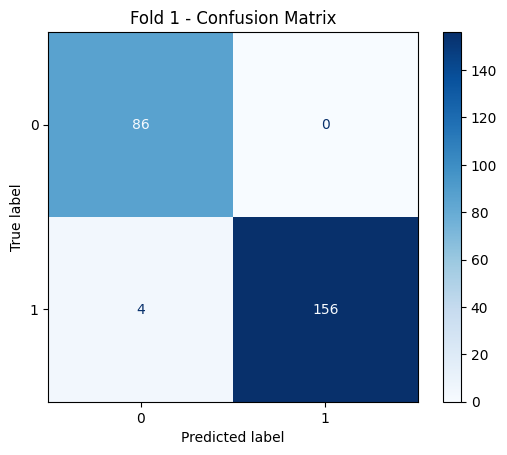

Model for fold 1 saved to result/fold_1_model.pth

=== Fold 3 / 5 ===
Epoch 1/100 | TrainLoss: 0.6707, TrainAcc: 0.6477 | TestLoss: 0.6491, TestAcc: 0.6545 | Precision: 0.6545, Recall: 1.0000, F1: 0.7912
Epoch 2/100 | TrainLoss: 0.5022, TrainAcc: 0.7566 | TestLoss: 0.2960, TestAcc: 0.9797 | Precision: 0.9937, Recall: 0.9752, F1: 0.9843
Epoch 3/100 | TrainLoss: 0.2513, TrainAcc: 0.9715 | TestLoss: 0.1645, TestAcc: 0.9797 | Precision: 0.9937, Recall: 0.9752, F1: 0.9843
Epoch 4/100 | TrainLoss: 0.1737, TrainAcc: 0.9715 | TestLoss: 0.1211, TestAcc: 0.9797 | Precision: 0.9937, Recall: 0.9752, F1: 0.9843
Epoch 5/100 | TrainLoss: 0.1519, TrainAcc: 0.9715 | TestLoss: 0.1077, TestAcc: 0.9797 | Precision: 0.9937, Recall: 0.9752, F1: 0.9843
Epoch 6/100 | TrainLoss: 0.1513, TrainAcc: 0.9715 | TestLoss: 0.1024, TestAcc: 0.9797 | Precision: 0.9937, Recall: 0.9752, F1: 0.9843
Epoch 7/100 | TrainLoss: 0.1390, TrainAcc: 0.9725 | TestLoss: 0.1006, TestAcc: 0.9797 | Precision: 0.9937, Recall: 0.9752, F1:

<Figure size 400x400 with 0 Axes>

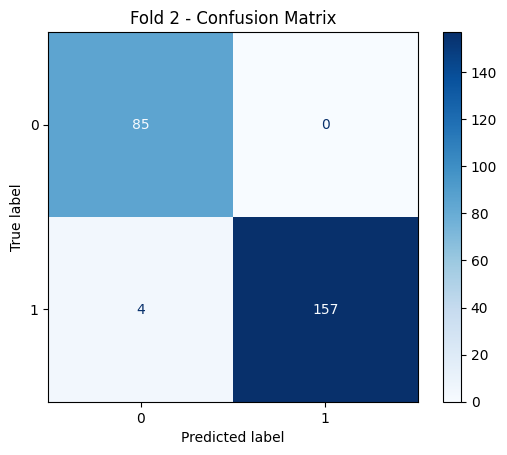

Model for fold 2 saved to result/fold_2_model.pth

=== Fold 4 / 5 ===
Epoch 1/100 | TrainLoss: 0.6596, TrainAcc: 0.6521 | TestLoss: 0.6278, TestAcc: 0.6531 | Precision: 0.6531, Recall: 1.0000, F1: 0.7901
Epoch 2/100 | TrainLoss: 0.4575, TrainAcc: 0.7854 | TestLoss: 0.3048, TestAcc: 0.9714 | Precision: 0.9693, Recall: 0.9875, F1: 0.9783
Epoch 3/100 | TrainLoss: 0.2403, TrainAcc: 0.9736 | TestLoss: 0.1918, TestAcc: 0.9714 | Precision: 0.9693, Recall: 0.9875, F1: 0.9783
Epoch 4/100 | TrainLoss: 0.1692, TrainAcc: 0.9736 | TestLoss: 0.1492, TestAcc: 0.9714 | Precision: 0.9693, Recall: 0.9875, F1: 0.9783
Epoch 5/100 | TrainLoss: 0.1444, TrainAcc: 0.9736 | TestLoss: 0.1379, TestAcc: 0.9714 | Precision: 0.9693, Recall: 0.9875, F1: 0.9783
Epoch 6/100 | TrainLoss: 0.1369, TrainAcc: 0.9736 | TestLoss: 0.1344, TestAcc: 0.9714 | Precision: 0.9693, Recall: 0.9875, F1: 0.9783
Epoch 7/100 | TrainLoss: 0.1234, TrainAcc: 0.9766 | TestLoss: 0.1323, TestAcc: 0.9714 | Precision: 0.9693, Recall: 0.9875, F1:

<Figure size 400x400 with 0 Axes>

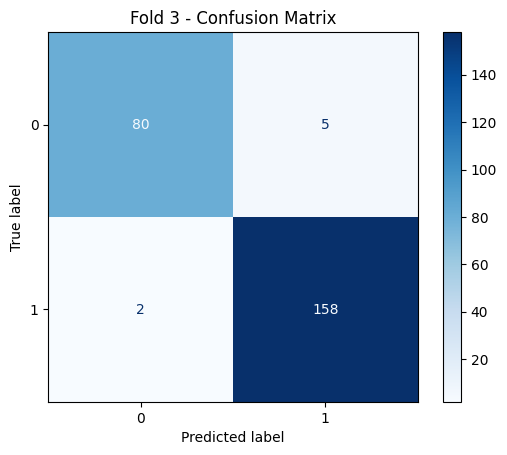

Model for fold 3 saved to result/fold_3_model.pth

=== Fold 5 / 5 ===
Epoch 1/100 | TrainLoss: 0.6612, TrainAcc: 0.6521 | TestLoss: 0.6346, TestAcc: 0.6531 | Precision: 0.6531, Recall: 1.0000, F1: 0.7901
Epoch 2/100 | TrainLoss: 0.4849, TrainAcc: 0.6948 | TestLoss: 0.3469, TestAcc: 0.9673 | Precision: 0.9634, Recall: 0.9875, F1: 0.9753
Epoch 3/100 | TrainLoss: 0.2748, TrainAcc: 0.9705 | TestLoss: 0.2369, TestAcc: 0.9673 | Precision: 0.9634, Recall: 0.9875, F1: 0.9753
Epoch 4/100 | TrainLoss: 0.1960, TrainAcc: 0.9756 | TestLoss: 0.1843, TestAcc: 0.9714 | Precision: 0.9636, Recall: 0.9938, F1: 0.9785
Epoch 5/100 | TrainLoss: 0.1565, TrainAcc: 0.9756 | TestLoss: 0.1601, TestAcc: 0.9714 | Precision: 0.9636, Recall: 0.9938, F1: 0.9785
Epoch 6/100 | TrainLoss: 0.1355, TrainAcc: 0.9766 | TestLoss: 0.1466, TestAcc: 0.9714 | Precision: 0.9636, Recall: 0.9938, F1: 0.9785
Epoch 7/100 | TrainLoss: 0.1291, TrainAcc: 0.9766 | TestLoss: 0.1401, TestAcc: 0.9714 | Precision: 0.9636, Recall: 0.9938, F1:

<Figure size 400x400 with 0 Axes>

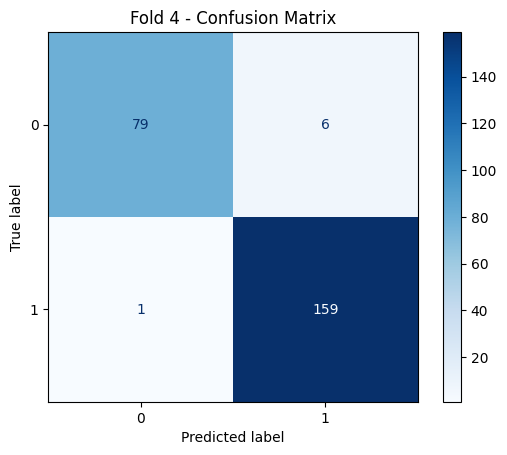

Model for fold 4 saved to result/fold_4_model.pth
All folds metrics saved to result/all_folds_metrics.csv

=== Final Metrics Summary Across All Folds ===
 Fold  Train Loss  Train Accuracy  Test Loss  Test Accuracy  Precision   Recall  F1-Score
    1    0.054120        0.985743   0.023084       0.991870   1.000000 0.987500  0.993711
    2    0.057220        0.985743   0.065197       0.983740   1.000000 0.975000  0.987342
    3    0.064997        0.977597   0.089362       0.983740   1.000000 0.975155  0.987421
    4    0.112111        0.976602   0.127758       0.971429   0.969325 0.987500  0.978328
    5    0.107908        0.976602   0.118517       0.971429   0.963636 0.993750  0.978462

=== Average Metrics Across All Folds ===
  Average Train Loss: 0.0793
  Average Train Accuracy: 0.9805
  Average Test Loss: 0.0848
  Average Test Accuracy: 0.9804
  Average Precision: 0.9866
  Average Recall: 0.9838
  Average F1-Score: 0.9851
Final metrics summary saved to result/final_metrics_summary.cs

In [ ]:
all_folds_metrics = []
fold_final_metrics = [] 

for fold_idx, (train_indices, test_indices) in enumerate(kfold.split(all_sequences, all_labels)):
    print(f"\n=== Fold {fold_idx+1} / {kfold.n_splits} ===")

    # 初始化 TensorBoard 的 SummaryWriter，將每個 fold 的日誌寫入不同的子目錄
    writer = SummaryWriter(log_dir=os.path.join(RESULT_DIR, f"fold_{fold_idx}"))
    
    # -- 建立當前fold的 train / test data --
    train_sequences = all_sequences[train_indices]
    train_labels    = all_labels[train_indices]
    test_sequences  = all_sequences[test_indices]
    test_labels     = all_labels[test_indices]
    
    # Dataset
    train_dataset = ChargingDataset(train_sequences, train_labels)
    test_dataset  = ChargingDataset(test_sequences,  test_labels)
    
    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)
    
    # 每個 fold 需要新建一個 LSTM 模型並重新訓練
    model = LSTMClassifier(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, NUM_CLASSES).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # 用於記錄歷次 epoch 的 loss/acc
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    
    test_precision_list = []
    test_recall_list = []
    test_f1_list = []
    
    # === 開始訓練 (num_epochs) ===
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x_batch.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        
        # epoch的 train loss/acc
        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total if total>0 else 0

        
        # 接著在同一epoch，做一次 test_loader 的評估
        epoch_test_loss, epoch_test_acc = evaluate_model(model, test_loader, criterion, device)

        # 在每個 epoch 結束時，計算 Precision, Recall, F1-score
        model.eval()
        preds = []
        trues = []
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(x_batch)
                _, predicted = torch.max(outputs, 1)
                preds.extend(predicted.cpu().numpy())
                trues.extend(y_batch.cpu().numpy())

        test_precision = precision_score(trues, preds, zero_division=0)
        test_recall = recall_score(trues, preds, zero_division=0)
        test_f1 = f1_score(trues, preds, zero_division=0)

        test_precision_list.append(test_precision)
        test_recall_list.append(test_recall)
        test_f1_list.append(test_f1)

        train_loss_list.append(epoch_train_loss)
        train_acc_list.append(epoch_train_acc)
        test_loss_list.append(epoch_test_loss)
        test_acc_list.append(epoch_test_acc)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
              f"TrainLoss: {epoch_train_loss:.4f}, TrainAcc: {epoch_train_acc:.4f} | "
              f"TestLoss: {epoch_test_loss:.4f}, TestAcc: {epoch_test_acc:.4f} | "
              f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

        # 將指標記錄到 TensorBoard
        writer.add_scalar('Loss/Train', epoch_train_loss, epoch)
        writer.add_scalar('Loss/Test', epoch_test_loss, epoch)
        writer.add_scalar('Accuracy/Train', epoch_train_acc, epoch)
        writer.add_scalar('Accuracy/Test', epoch_test_acc, epoch)
        writer.add_scalar('Precision/Test', test_precision, epoch)
        writer.add_scalar('Recall/Test', test_recall, epoch)
        writer.add_scalar('F1_Score/Test', test_f1, epoch)
    
    dummy_input = torch.randn(1, MAX_SEQ_LEN, INPUT_DIM).to(device)
    writer.add_graph(model, dummy_input)                                              
    writer.close()

    final_train_loss = train_loss_list[-1]
    final_train_acc = train_acc_list[-1]
    final_test_loss = test_loss_list[-1]
    final_test_acc = test_acc_list[-1]
    final_precision = test_precision_list[-1]
    final_recall = test_recall_list[-1]
    final_f1 = test_f1_list[-1]

    print(f"\nFold {fold_idx+1} Final Metrics:")
    print(f"  Train Loss: {final_train_loss:.4f}")
    print(f"  Train Accuracy: {final_train_acc:.4f}")
    print(f"  Test Loss: {final_test_loss:.4f}")
    print(f"  Test Accuracy: {final_test_acc:.4f}")
    print(f"  Precision: {final_precision:.4f}")
    print(f"  Recall: {final_recall:.4f}")
    print(f"  F1-Score: {final_f1:.4f}")

    fold_final_metrics.append({
        'Fold': fold_idx + 1,
        'Train Loss': final_train_loss,
        'Train Accuracy': final_train_acc,
        'Test Loss': final_test_loss,
        'Test Accuracy': final_test_acc,
        'Precision': final_precision,
        'Recall': final_recall,
        'F1-Score': final_f1
    })


    epochs_range = range(1, NUM_EPOCHS+1)
    fold_metrics_df = pd.DataFrame({
        'Epoch': epochs_range,
        'Train Loss': train_loss_list,
        'Test Loss': test_loss_list,
        'Train Accuracy': train_acc_list,
        'Test Accuracy': test_acc_list,
        'Test Precision': test_precision_list,
        'Test Recall': test_recall_list,
        'Test F1-score': test_f1_list
    })
    fold_metrics_df['Fold'] = fold_idx 
    all_folds_metrics.append(fold_metrics_df)

    # === 混淆矩陣 ===
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(x_batch)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            trues.extend(y_batch.cpu().numpy())

    cm = confusion_matrix(trues, preds, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

    plt.figure(figsize=(4,4))
    disp.plot(values_format='d', cmap='Blues')
    plt.title(f"Fold {fold_idx} - Confusion Matrix")
    
    # 儲存到 result/ 目錄
    fold_cm_path = os.path.join(RESULT_DIR, f"fold_{fold_idx}_cm.pdf")
    plt.savefig(fold_cm_path, bbox_inches='tight')
    fold_cm_path = os.path.join(RESULT_DIR, f"fold_{fold_idx}_cm.svg")
    plt.savefig(fold_cm_path, bbox_inches='tight')
    plt.show()

    # 儲存模型
    model_save_path = os.path.join(RESULT_DIR, f"fold_{fold_idx}_model.pth")
    torch.save(model.state_dict(), model_save_path) # 新增：儲存模型狀態字典
    print(f"Model for fold {fold_idx} saved to {model_save_path}") # 新增：印出模型儲存訊息

# 所有 fold 循環結束後，將 all_folds_metrics 列表中的 DataFrame 合併
all_metrics_df = pd.concat(all_folds_metrics, ignore_index=True)

# 將合併後的 DataFrame 儲存到 CSV 檔案
all_metrics_csv_path = os.path.join(RESULT_DIR, "all_folds_metrics.csv")
all_metrics_df.to_csv(all_metrics_csv_path, index=False)
print(f"All folds metrics saved to {all_metrics_csv_path}")

# 新增：總結每個 fold 的最終指標並計算平均值
final_metrics_df = pd.DataFrame(fold_final_metrics)
print("\n=== Final Metrics Summary Across All Folds ===")
print(final_metrics_df.to_string(index=False))

# 計算並顯示平均值
mean_metrics = final_metrics_df.mean(numeric_only=True)
print("\n=== Average Metrics Across All Folds ===")
print(f"  Average Train Loss: {mean_metrics['Train Loss']:.4f}")
print(f"  Average Train Accuracy: {mean_metrics['Train Accuracy']:.4f}")
print(f"  Average Test Loss: {mean_metrics['Test Loss']:.4f}")
print(f"  Average Test Accuracy: {mean_metrics['Test Accuracy']:.4f}")
print(f"  Average Precision: {mean_metrics['Precision']:.4f}")
print(f"  Average Recall: {mean_metrics['Recall']:.4f}")
print(f"  Average F1-Score: {mean_metrics['F1-Score']:.4f}")

# 儲存總結表格到 CSV
final_metrics_csv_path = os.path.join(RESULT_DIR, "final_metrics_summary.csv")
final_metrics_df.to_csv(final_metrics_csv_path, index=False)
print(f"Final metrics summary saved to {final_metrics_csv_path}")

# 圖表繪製

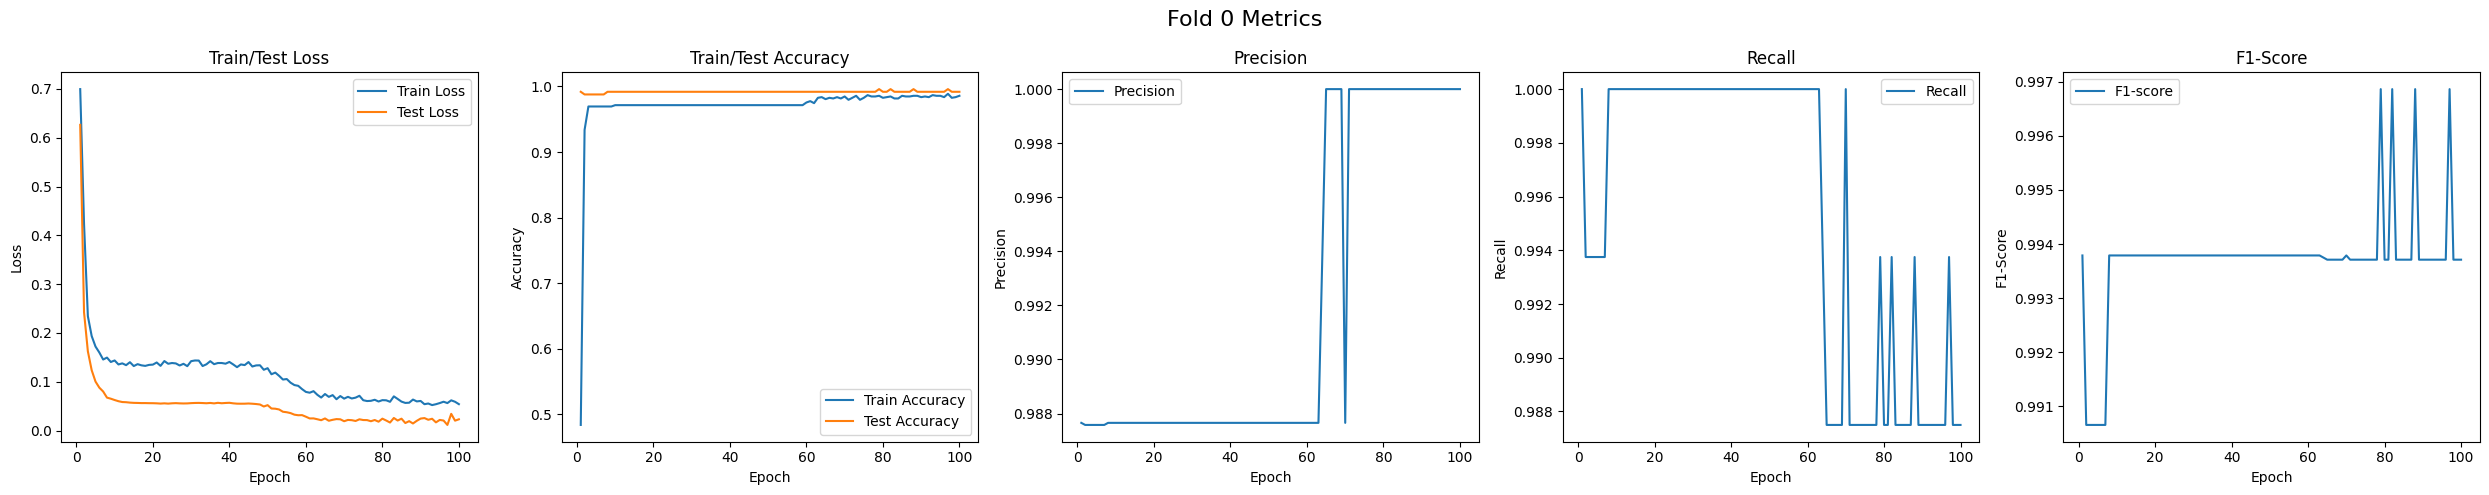

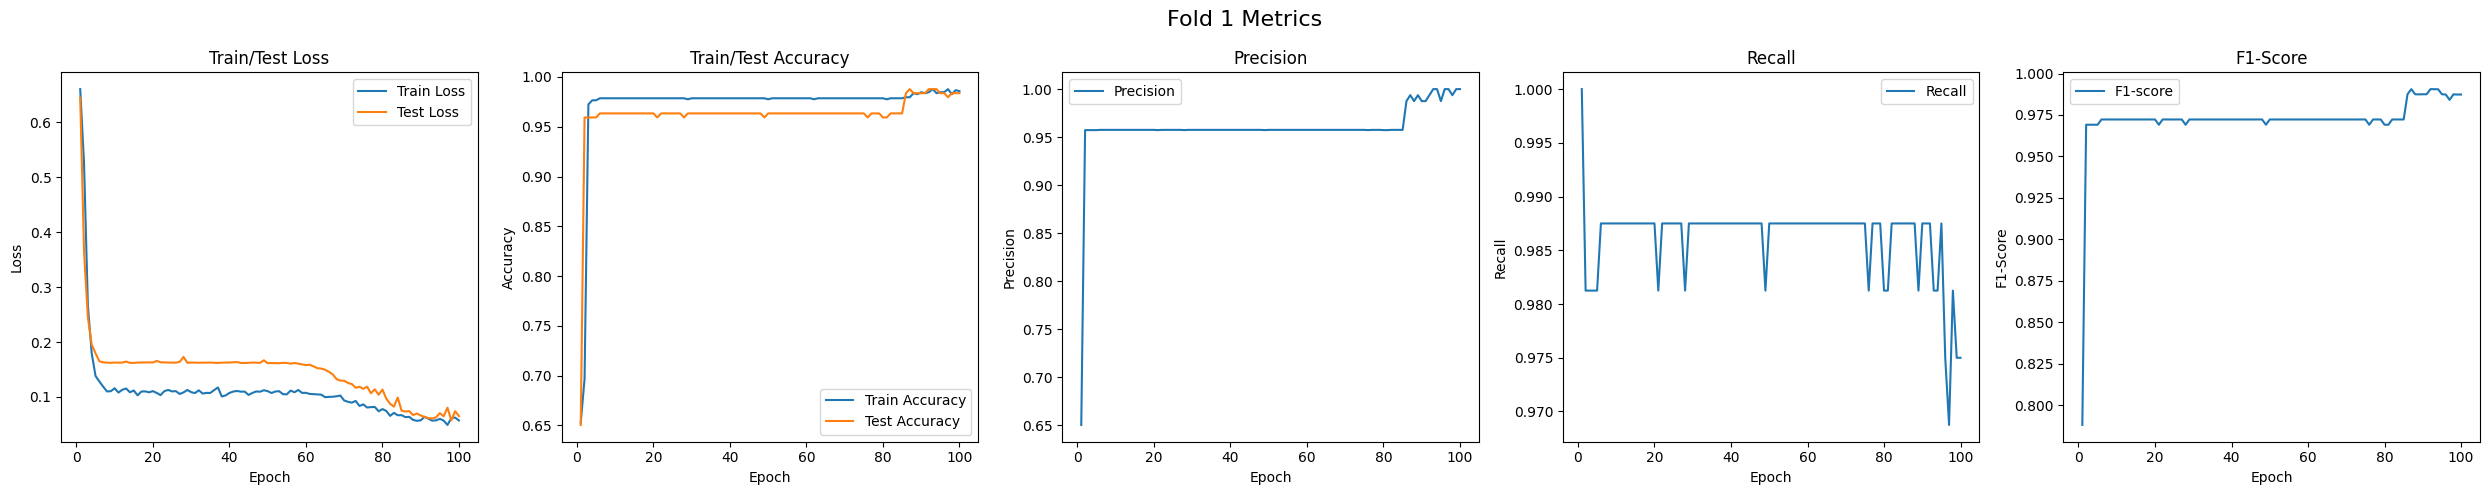

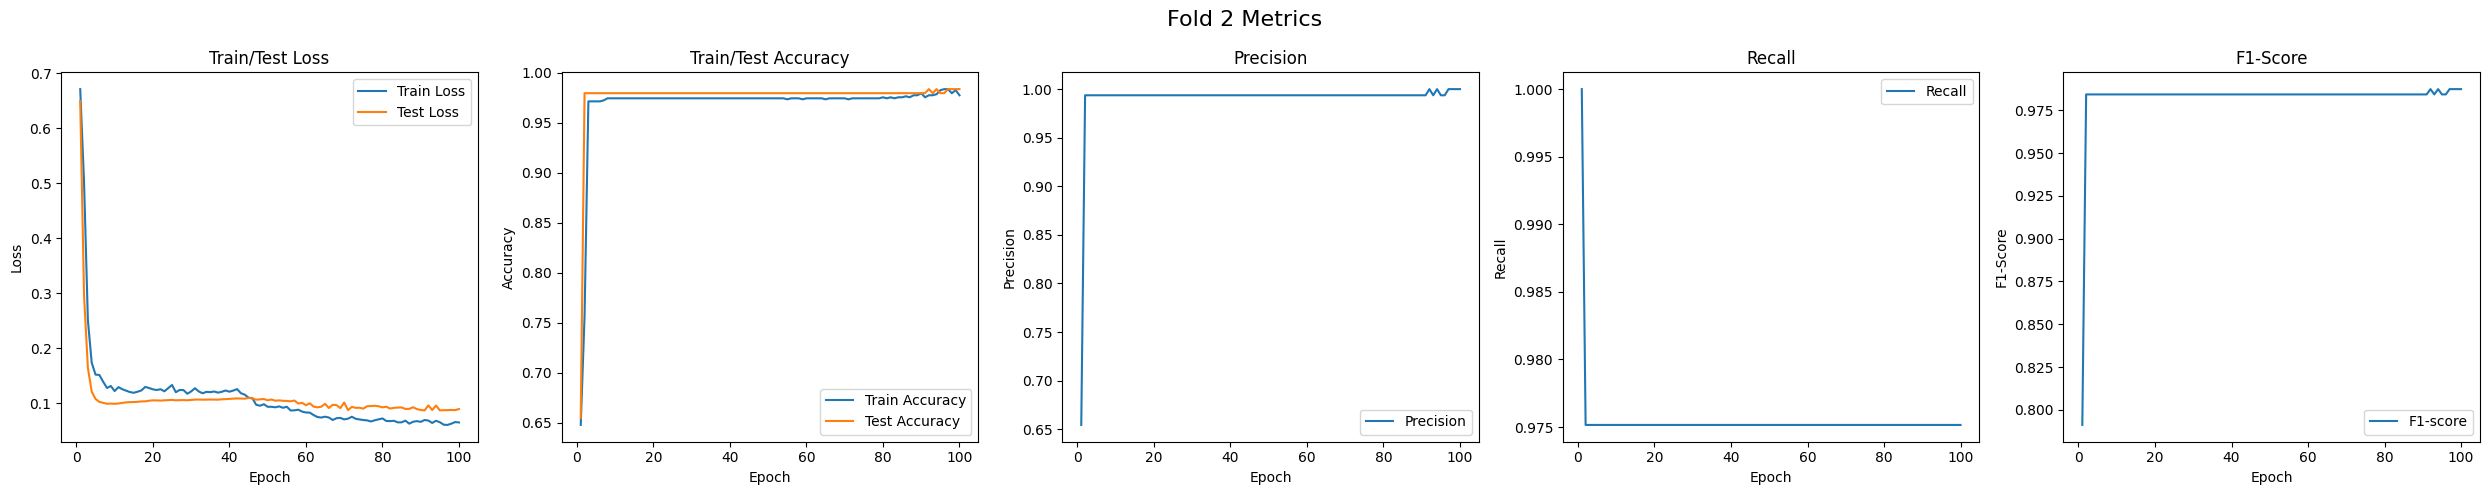

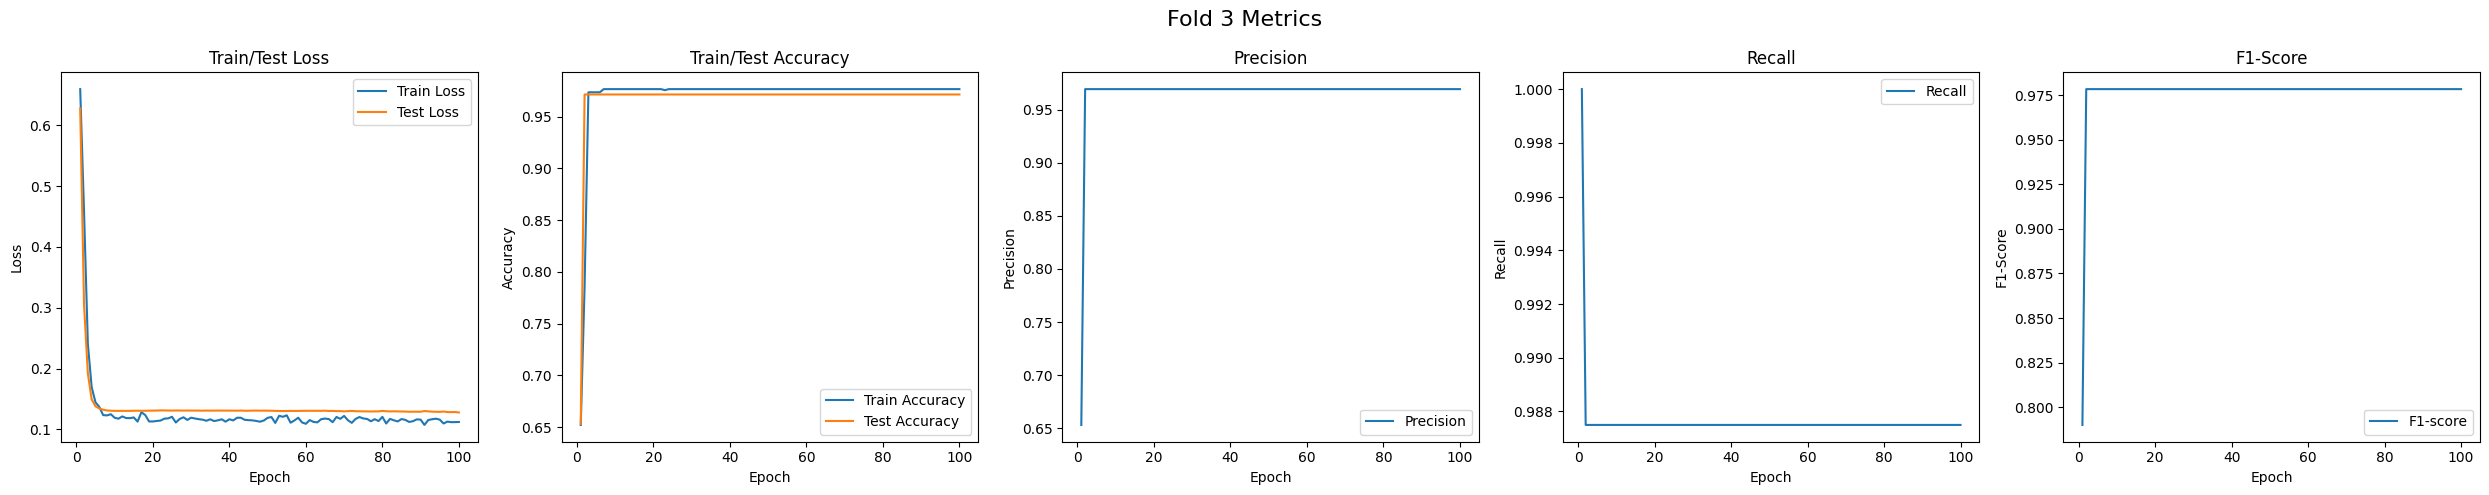

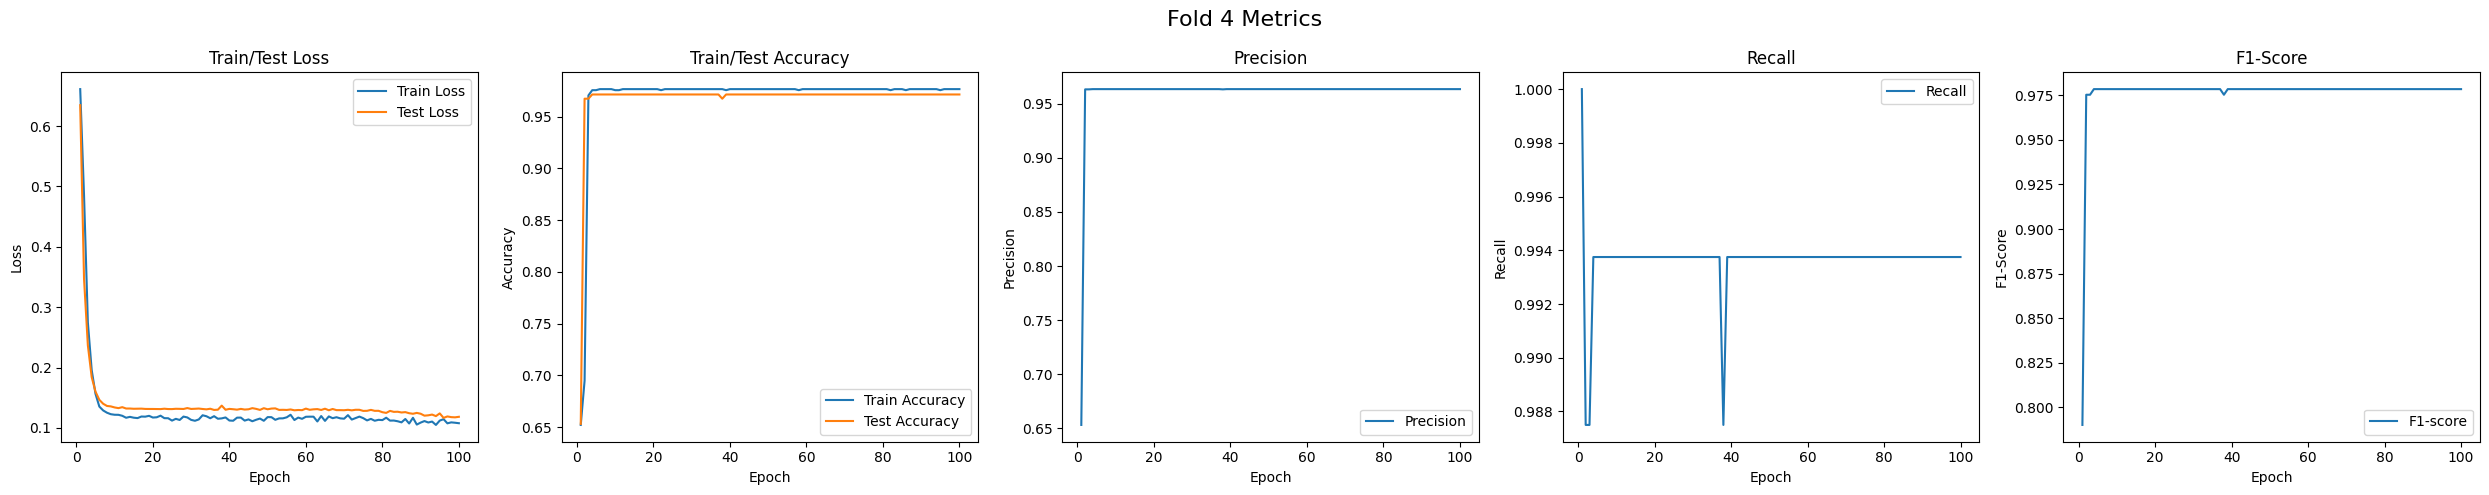

In [21]:
folds = all_metrics_df['Fold'].unique()

for fold in folds:
    fold_data = all_metrics_df[all_metrics_df['Fold'] == fold]

    # with plt.style.context(["science"]):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    fig.suptitle(f'Fold {fold} Metrics', fontsize=16)

    # Train/Test Loss
    axes[0].plot(fold_data['Epoch'], fold_data['Train Loss'], label='Train Loss')
    axes[0].plot(fold_data['Epoch'], fold_data['Test Loss'], label='Test Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Train/Test Loss')
    axes[0].legend()

    # Train/Test Accuracy
    axes[1].plot(fold_data['Epoch'], fold_data['Train Accuracy'], label='Train Accuracy')
    axes[1].plot(fold_data['Epoch'], fold_data['Test Accuracy'], label='Test Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Train/Test Accuracy')
    axes[1].legend()

    # Precision
    axes[2].plot(fold_data['Epoch'], fold_data['Test Precision'], label='Precision') 
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision')
    axes[2].legend()

    # Recall
    axes[3].plot(fold_data['Epoch'], fold_data['Test Recall'], label='Recall') 
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('Recall')
    axes[3].set_title('Recall')
    axes[3].legend()

    # F1-score
    axes[4].plot(fold_data['Epoch'], fold_data['Test F1-score'], label='F1-score') 
    axes[4].set_xlabel('Epoch')
    axes[4].set_ylabel('F1-Score')
    axes[4].set_title('F1-Score')
    axes[4].legend()

    plt.tight_layout()
    fold_plot_path = os.path.join(RESULT_DIR, f"fold_{fold}_all_metrics.pdf")
    plt.savefig(fold_plot_path, bbox_inches='tight')
    fold_plot_path = os.path.join(RESULT_DIR, f"fold_{fold}_all_metrics.svg")
    plt.savefig(fold_plot_path, bbox_inches='tight')
    plt.show()
    plt.close(fig) 